# DAT 205 Project - Transform data
## By Dennis Hung
## Version 1
## Code DRAFT 2021-03-11

## Updates
#### 


##  Reference

#### How to Get NBA Data Using the nba_api Python Module (Beginner). Retrieved from Plyaing Numbers: 

https://www.playingnumbers.com/2019/12/how-to-get-nba-data-using-the-nba_api-python-module-beginner/

#### Patel, S. (2020, August 19). swar / nba_api. Retrieved from GitHub: 

https://github.com/swar/nba_api/blob/master/docs/table_of_contents.md

#### Issues

https://github.com/swar/nba_api/issues/124



# Note: 
#### This code relies on the CSV output from "DAT 205-Group01-NBA-HistPlayGameLogs.ipynb" as the dataset for this transformation.

# Section 0: Function definitions

hms_string(sec_elapsed)


In [1]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60))/60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h,m,s)

# Null field analysis
def nullFieldAnalysis(df):
    df_missingDataInfo = pd.DataFrame({'Count': df.isnull().sum(), 'Percent': 100*df.isnull().sum()/len(df)})
    #Printing the columns with over XX% of missing values (ie 60 = 60%) This is set to 0 for 0%
    null_threshold = 0 
    print("")
    print("")
    print("==== Null value analysis ====")
    return df_missingDataInfo[df_missingDataInfo['Percent'] > null_threshold].sort_values(by=['Percent'])


# Section 1: Import libraries

In [2]:
# Initialized required packages
# Standard packages
import numpy as np
import pandas as pd
import scipy as sp
import csv
import time

# Graphing packages
import seaborn as sns

# import matplotlib
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import matplotlib.lines as mlines

# Data preparation
from sklearn.preprocessing import LabelEncoder

# Modeling packages
# import tensorflow as tf
# import sklearn as skl
from sklearn.model_selection import train_test_split

# Regression modeling
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# from sklearn.model_selection import cross_val_score

# Confusion matrix, Accuracy, sensitivity and specificity
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

# from sklearn.feature_selection import VarianceThreshold 
from sklearn.feature_selection import RFE 
# from sklearn.feature_selection import RFECV

# Clustering
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Following code is being deprecated
# from sklearn.datasets.samples_generator import make_blobs

# Initialize variables if there is any debugging required
# Insert following line and activate the debugging.
# # VALIDATION CODE 
# if debug_active == 'yes':
# 
# Use "display(df)"" if the result command is "df" to retain the same format



start_time = time.time()

# Section 2: Configuration of variables

Must manually set the following variables

gameTypeListed as one of the following: 'Pre Season', 'Regular Season', 'Playoffs'

seasonsListed for the game season in this format '2015-16'. Have at least 2 values

In [3]:
# pick who is running the code and comment out the others
# coder = 'bhavika'
# coder = 'cindy'
coder = 'dennis'


debug_active = 'yes'
loop_max = 100
# showNumRecs = 15
numFormat = '{:.4f}'

# Filter the dataset by team
allTeamsList = ['CLE', 'LAC', 'NOH', 'WAS', 'ORL', 'NJN', 'PHX', 'DET', 'IND', \
       'CHA', 'DAL', 'ATL', 'NYK', 'CHI', 'BOS', 'MIN', 'PHI', 'HOU', \
       'POR', 'TOR', 'SAC', 'UTA', 'GSW', 'MIA', 'SEA', 'MEM', 'LAL', \
       'SAS', 'DEN', 'MIL', 'NOK', 'ZAK', 'CHN', 'PAN', 'RMA', 'MMT', \
       'MTA', 'MAL', 'LRO', 'EPT', 'OKC', 'LRY', 'BAR', 'MOS', 'OLP', \
       'PAR', 'LAB', 'MAC', 'MLN', 'BKN', 'FCB', 'RMD', 'MPS', 'EAM', \
       'ALB', 'FBU', 'NOP', 'UBB', 'FLA', 'BAU', 'FEN', 'SLA', 'SDS', \
       'BNE', 'MEL', 'SYD', 'GUA', 'PER', 'ADL', 'NZB', 'BJD', 'FRA']
teamSelected = 'TOR'

# Train/Test configuration
# Select a season 
# gameTypeListed = ['Pre Season', 'Regular Season', 'Playoffs']
# gameTypeListed_code = [1, 2, 0]
gameType = 2
test_size_val = 0.30

# Model Analysis Configuration
random_state_val = 42

# Setup file name for csv or Excel (.xlsx)
if coder == 'bhavika':
    filename = 'D:/McMaster/DAT205/Capstone/Data/HistoricalGameLogs_2004-05_to_2019-20_ALL.csv'
elif coder == 'dennis':
    # filename = './HistoricalGameLogs_2007-08_to_2008-09_ALL.csv'
    filename = './HistoricalGameLogs_2004-05_to_2019-20_ALL.csv'
# filename = filename + seasonStart + '_to_' + seasonEnd + '_' + gameType + '.csv'
# filename = filename + seasonStart + '_to_' + seasonEnd + '_ALL' + '.csv'


# Update player stats per game each season

gameTypeListed = ['Pre Season', 'Regular Season', 'Playoffs']

# Option 1: For all currently possible seasons
# seasonsListed = ['1946-47', '1947-48', '1948-49', '1949-50'
# , '1950-51', '1951-52', '1952-53', '1953-54', '1954-55', '1955-56', '1956-57', '1957-58', '1958-59', '1959-60'
# , '1960-61', '1961-62', '1962-63', '1963-64', '1964-65', '1965-66', '1966-67', '1967-68', '1968-69', '1969-70'
# , '1970-71', '1971-72', '1972-73', '1973-74', '1974-75', '1975-76', '1976-77', '1977-78', '1978-79', '1979-80'
# , '1980-81', '1981-82', '1982-83', '1983-84', '1984-85', '1985-86', '1986-87', '1987-88', '1988-89', '1989-90'
# , '1990-91', '1991-92', '1992-93', '1993-94', '1994-95', '1995-96', '1996-97', '1997-98', '1998-99', '1999-00'
# , '2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10'
# , '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20'
# , '2020-21']

seasonsListed = ['2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10'
, '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']

seasonStart = seasonsListed[0]
seasonEnd = seasonsListed[-1]

# Request info for each season in the list
df_gamelogs_player = []
countFirstYear = 0

# Section 3: Upload the dataset and initial analysis

In [4]:
# load the CSV or Excel file 
# Note the other option in Jupyter Notebook is to use the upload the csv files before running the code

# lst of column names which needs to be string
lst_str_cols = ['GAME_ID']
# use dictionary comprehension to make dict of dtypes
dict_dtypes = {x : 'str'  for x in lst_str_cols}
# use dict on dtypes
df = pd.read_csv(filename, dtype=dict_dtypes)

# Excel file import
# df = pd.read_excel(filename)


# Remove duplicate index from import
unwanted_list = ['Unnamed: 0']

X_headers_list = df.columns.tolist()

for x in unwanted_list:
    X_headers_list.remove(x)

# Display current dataframe
df_Initial = df[X_headers_list]

# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Initial)
    # Examine shape of dataframe
    display(df_Initial.shape)
    # Examine the type of attributes in the dataframe
    print("Shape of the dataset")
    df_Initial.info()
    # Describe the numerical data
    df_Initial.describe()
    


,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type
0,2004-05,2400,Drew Gooden,1610612739,CLE,Cleveland Cavaliers,0020401218,2005-04-20T00:00:00,CLE @ TOR,W,...,0,1,0,3,0,6,12,0,0,Regular Season
1,2004-05,2060,Marko Jaric,1610612746,LAC,Los Angeles Clippers,0020401225,2005-04-20T00:00:00,LAC @ NOH,W,...,0,0,0,1,0,14,11,0,0,Regular Season
2,2004-05,2544,LeBron James,1610612739,CLE,Cleveland Cavaliers,0020401218,2005-04-20T00:00:00,CLE @ TOR,W,...,0,1,1,1,0,27,9,1,1,Regular Season
3,2004-05,2561,David West,1610612740,NOH,New Orleans Hornets,0020401225,2005-04-20T00:00:00,NOH vs. LAC,L,...,0,1,1,5,0,11,7,0,0,Regular Season
4,2004-05,2413,Juan Dixon,1610612764,WAS,Washington Wizards,0020401222,2005-04-20T00:00:00,WAS @ NYK,L,...,0,0,0,2,0,13,0,0,0,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465060,2019-20,204060,Joe Ingles,1610612762,UTA,Utah Jazz,0041900161,2020-08-17T00:00:00,UTA @ DEN,L,...,1,0,0,3,5,19,-14,0,0,Playoffs
465061,2019-20,1626144,Emmanuel Mudiay,1610612762,UTA,Utah Jazz,0041900161,2020-08-17T00:00:00,UTA @ DEN,L,...,0,0,0,0,1,1,1,0,0,Playoffs
465062,2019-20,203924,Jerami Grant,1610612743,DEN,Denver Nuggets,0041900161,2020-08-17T00:00:00,DEN vs. UTA,W,...,1,1,0,2,6,19,1,0,0,Playoffs
465063,2019-20,1626196,Josh Richardson,1610612755,PHI,Philadelphia 76ers,0041900121,2020-08-17T00:00:00,PHI @ BOS,L,...,0,0,2,2,2,18,-10,0,0,Playoffs


(465065, 35)

Shape of the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465065 entries, 0 to 465064
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SEASON_YEAR        465065 non-null  object 
 1   PLAYER_ID          465065 non-null  int64  
 2   PLAYER_NAME        464325 non-null  object 
 3   TEAM_ID            465065 non-null  int64  
 4   TEAM_ABBREVIATION  465065 non-null  object 
 5   TEAM_NAME          465065 non-null  object 
 6   GAME_ID            465065 non-null  object 
 7   GAME_DATE          465065 non-null  object 
 8   MATCHUP            465065 non-null  object 
 9   WL                 465016 non-null  object 
 10  MIN                465065 non-null  float64
 11  FGM                465065 non-null  int64  
 12  FGA                465065 non-null  int64  
 13  FG_PCT             465065 non-null  float64
 14  FG3M               465065 non-null  int64  
 15  FG3A               465065 non-

## Initial Analysis

In [5]:
# Display the headers of columns that use descriptive or non-numerical values
categorical_Features = df_Initial.dtypes[df_Initial.dtypes == "object"].index.tolist()

# VALIDATION CODE 
if debug_active == 'yes':
    print("VALIDATION CODE")
    print(categorical_Features)

# Describe the categorical data
print("")
print("")
print("==== Description of the categorical features ====")
display(df_Initial[categorical_Features].describe())

# # Null field analysis
nullFieldAnalysis(df_Initial)
# # Null field analysis
# df_missingDataInfo = pd.DataFrame({'Count': df_Initial.isnull().sum(), 'Percent': 100*df_Initial.isnull().sum()/len(df)})

# #Printing the columns with over XX% of missing values (ie 60 = 60%) This is set to 0 for 0%
# null_threshold = 0 
# print("")
# print("")
# print("==== Null value analysis ====")
# df_missingDataInfo[df_missingDataInfo['Percent'] > null_threshold].sort_values(by=['Percent'])

VALIDATION CODE
['SEASON_YEAR', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'Game_Type']


==== Description of the categorical features ====


,SEASON_YEAR,PLAYER_NAME,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,Game_Type
count,465065,464325,465065,465065,465065,465065,465065,465016,465065
unique,16,2389,72,78,22104,3563,2392,2,3
top,2015-16,LeBron James,SAS,San Antonio Spurs,0010500120,2018-10-05T00:00:00,LAL vs. DEN,L,Regular Season
freq,30809,1514,17937,17937,36,339,604,232520,399371




==== Null value analysis ====


,Count,Percent
WL,49,0.010536
PLAYER_NAME,740,0.159118


# 

# Section 4: Transforming/cleansing the data 

## Data cleansing of nulls (Not working)

## Correction to missing PreSeason games WL values only 

49 records 

2007-08 
GAME_ID 0010700072 / 2007-10-19
BOS vs NJN   W 36 to L 33

2008-09 
GAME_ID 0010800035 / 2008-10-11
DEN vs PHX   W 77 to L 72
Note some player game data seems missing

## Corrected missing player name data

740 records (727 preseason and 13 regular season)

This is not important as the player names are excluded from the analysis



In [6]:
# # df_missingDataInfo[df_missingDataInfo['Percent'] > null_threshold].loc[df_missingDataInfo[]]

# missingDataInfo_List = df_missingDataInfo.loc[df_missingDataInfo['Count']>0].index.tolist()
# # ['PLAYER_NAME', 'WL']

# numOfRows = len(df_missingDataInfo.index)

# for missingDataInfo_Value in missingDataInfo_List:
#     df_missingDataInfo[df_missingDataInfo[index] = missingDataInfo_Value]


# # Pull player data
# from nba_api.stats.static import players
# player_dict = players.get_players()


# # Use ternary operator or write function 
# # Names are case sensitive
# bron = [player for player in player_dict if player['full_name'] == 'LeBron James'][0]
# bron_id = bron['id']

# # find team Ids
# from nba_api.stats.static import teams 
# teams = teams.get_teams()
# GSW = [x for x in teams if x['full_name'] == 'Golden State Warriors'][0]
# GSW_id = GSW['id']

## Section 4a: Enhance the data

### PIE

Name Player Impact Estimate 

Definition PIE measures a player's overall statistical contribution against the total statistics in games they play in. PIE yields results which are comparable to other advanced statistics (e.g. PER) using a simple formula.

Formula (PTS + FGM + FTM - FGA - FTA + DREB + (.5 * OREB) + AST + STL + (.5 * BLK) - PF - TO) / (GmPTS + GmFGM + GmFTM - GmFGA - GmFTA + GmDREB + (.5 * GmOREB) + GmAST + GmSTL + (.5 * GmBLK) - GmPF - GmTO)

In [7]:
df_TF = df_Initial
totalNumRec = df_TF.shape[0]
print(totalNumRec)
display(df_TF)
print(df_TF.columns)

465065


,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type
0,2004-05,2400,Drew Gooden,1610612739,CLE,Cleveland Cavaliers,0020401218,2005-04-20T00:00:00,CLE @ TOR,W,...,0,1,0,3,0,6,12,0,0,Regular Season
1,2004-05,2060,Marko Jaric,1610612746,LAC,Los Angeles Clippers,0020401225,2005-04-20T00:00:00,LAC @ NOH,W,...,0,0,0,1,0,14,11,0,0,Regular Season
2,2004-05,2544,LeBron James,1610612739,CLE,Cleveland Cavaliers,0020401218,2005-04-20T00:00:00,CLE @ TOR,W,...,0,1,1,1,0,27,9,1,1,Regular Season
3,2004-05,2561,David West,1610612740,NOH,New Orleans Hornets,0020401225,2005-04-20T00:00:00,NOH vs. LAC,L,...,0,1,1,5,0,11,7,0,0,Regular Season
4,2004-05,2413,Juan Dixon,1610612764,WAS,Washington Wizards,0020401222,2005-04-20T00:00:00,WAS @ NYK,L,...,0,0,0,2,0,13,0,0,0,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465060,2019-20,204060,Joe Ingles,1610612762,UTA,Utah Jazz,0041900161,2020-08-17T00:00:00,UTA @ DEN,L,...,1,0,0,3,5,19,-14,0,0,Playoffs
465061,2019-20,1626144,Emmanuel Mudiay,1610612762,UTA,Utah Jazz,0041900161,2020-08-17T00:00:00,UTA @ DEN,L,...,0,0,0,0,1,1,1,0,0,Playoffs
465062,2019-20,203924,Jerami Grant,1610612743,DEN,Denver Nuggets,0041900161,2020-08-17T00:00:00,DEN vs. UTA,W,...,1,1,0,2,6,19,1,0,0,Playoffs
465063,2019-20,1626196,Josh Richardson,1610612755,PHI,Philadelphia 76ers,0041900121,2020-08-17T00:00:00,PHI @ BOS,L,...,0,0,2,2,2,18,-10,0,0,Playoffs


Index(['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'DD2', 'TD3', 'Game_Type'],
      dtype='object')


In [8]:
# # create UID_STG for SEASON_YEAR', 'TEAM_ID', 'GAME_ID'
# df_TF['UID_STG'] = 'new field'

In [9]:
# display(df_TF)
# df_TF.to_csv('DAT205_Output_TF.csv') 

In [10]:
# # Reference to sum column values under certain condition.
# # https://intellipaat.com/community/49/how-do-i-sum-values-in-a-column-that-match-a-given-condition-using-pandas
# # https://cmdlinetips.com/2018/01/how-to-get-unique-values-from-a-column-in-pandas-data-frame/  
# # https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html


# # for currNumRec in (0,totalNumRec,1):
# # currNumRec = 4
# # pick by cell in dataframe

# # Update UID_STG with calculated values  'SEASON_YEAR', 'TEAM_ID', 'GAME_ID'
# totalNumRec = 58288

# for currNumRec in range(totalNumRec):
#     df_TF['UID_STG'].loc[currNumRec] = df_TF['SEASON_YEAR'].loc[currNumRec] + str(df_TF['TEAM_ID'].loc[currNumRec]) +  df_TF['GAME_ID'].loc[currNumRec]


# display(df_TF['PF'].loc[currNumRec])

# # gmPTS = df_TF.loc[df_TF[]

# PIE = (df_TF['PTS'].loc[currNumRec] + df_TF['FGM'].loc[currNumRec] + df_TF['FTM'].loc[currNumRec] \
#     - df_TF['FGA'].loc[currNumRec] - df_TF['FTA'].loc[currNumRec] \
#     + df_TF['DREB'].loc[currNumRec] + (0.5 * df_TF['OREB'].loc[currNumRec]) \
#     + df_TF['AST'].loc[currNumRec] + df_TF['STL'].loc[currNumRec] + (0.5 * df_TF['BLK'].loc[currNumRec]) \
#     - df_TF['PF'].loc[currNumRec] - df_TF['TOV'].loc[currNumRec])


# display(df_TF)
# print(df_TF['PLAYER_NAME'].loc[currNumRec])
# print(PIE)
#     # PTS + FGM + FTM - FGA - FTA + DREB + (.5 * OREB) + AST + STL + (.5 * BLK) - PF - TO) / (GmPTS + GmFGM + GmFTM - GmFGA - GmFTA + GmDREB + (.5 * GmOREB) + GmAST + GmSTL + (.5 * GmBLK) - GmPF - GmTO)

In [11]:
# df_UID_STG_List = ['UID_STG', 'GmPTS', 'GmFGM', 'GmFTM', 'GmFGA', 'GmFTA', 'GmDREB', 'GmOREB', 'GmAST', 'GmSTL', 'GmBLK', 'GmPF', 'GmTO']

# for listValue in df_UID_STG_List
#     df_UID_STG[listValue].isnull

# # df_TF['UID_STG'].unique()


In [12]:
# print(totalNumRec)
# print(currNumRec)

In [13]:
# If a specific team is selected by 'TEAM_ABBREVIATION' then recreate the dataframe with this filter else use the entire dataset as is.
if teamSelected in allTeamsList:
    df_TF = df_TF[df_TF['TEAM_ABBREVIATION']==teamSelected]
else:
    df_TF    
display(df_TF)

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type
24,2004-05,2776,Pape Sow,1610612761,TOR,Toronto Raptors,0020401218,2005-04-20T00:00:00,TOR vs. CLE,L,...,2,1,1,5,0,6,-14,0,0,Regular Season
65,2004-05,1425,Aaron Williams,1610612761,TOR,Toronto Raptors,0020401218,2005-04-20T00:00:00,TOR vs. CLE,L,...,0,0,0,0,0,0,-4,0,0,Regular Season
106,2004-05,1747,Rafer Alston,1610612761,TOR,Toronto Raptors,0020401218,2005-04-20T00:00:00,TOR vs. CLE,L,...,0,0,0,1,0,3,-17,0,0,Regular Season
125,2004-05,1960,Milt Palacio,1610612761,TOR,Toronto Raptors,0020401218,2005-04-20T00:00:00,TOR vs. CLE,L,...,0,1,0,2,0,2,-11,0,0,Regular Season
131,2004-05,2241,Omar Cook,1610612761,TOR,Toronto Raptors,0020401218,2005-04-20T00:00:00,TOR vs. CLE,L,...,2,1,1,0,0,19,8,0,0,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465020,2019-20,201586,Serge Ibaka,1610612761,TOR,Toronto Raptors,0041900111,2020-08-17T00:00:00,TOR vs. BKN,W,...,0,1,0,2,2,22,17,0,0,Playoffs
465022,2019-20,1628384,OG Anunoby,1610612761,TOR,Toronto Raptors,0041900111,2020-08-17T00:00:00,TOR vs. BKN,W,...,1,2,0,5,1,12,18,0,0,Playoffs
465035,2019-20,1629744,Matt Thomas,1610612761,TOR,Toronto Raptors,0041900111,2020-08-17T00:00:00,TOR vs. BKN,W,...,1,0,0,1,0,0,11,0,0,Playoffs
465047,2019-20,1627832,Fred VanVleet,1610612761,TOR,Toronto Raptors,0041900111,2020-08-17T00:00:00,TOR vs. BKN,W,...,2,1,1,2,2,30,14,1,0,Playoffs


## Section 4b: Remove (Stage 1) from dataframe the unwanted numerical/categorical features

In [14]:
# Gather current list of features
numerical_Features = df_TF.columns.tolist()

# All possible features
# ['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'DD2', 'TD3', 'Game_Type']

for i in categorical_Features: 
    numerical_Features.remove(i)

# Lists unwanted features
unwanted_numerical_Features = ['PLAYER_ID', 'TEAM_ID']
unwanted_categorical_Features = ['PLAYER_NAME', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP']
unwanted_list_01 = unwanted_numerical_Features + unwanted_categorical_Features
X_headers_list = df_TF.columns.tolist()

for i in unwanted_list_01:
    X_headers_list.remove(i)

# Reset new dataframe with desired features
df_Reduced = df_TF[X_headers_list]

# Remaining attributes
# VALIDATION CODE 
if debug_active == 'yes':
    display(X_headers_list)

['SEASON_YEAR',
 'WL',
 'MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'DD2',
 'TD3',
 'Game_Type']

## Section 4c: Transform categorical feature (WL) using value replace

In [15]:
cleaned_categorical_Features = ['WL', 'Game_Type']
cleanupValue = {'WL': {'W': 1, 'L': 0}, 'Game_Type': {'Pre Season': 0, 'Regular Season': 1, 'Playoffs': 2}}
df_Reduced = df_Reduced.replace(cleanupValue)

# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Reduced)

,SEASON_YEAR,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type
24,2004-05,0,22.133333,2,4,0.500,0,0,0.000,2,...,2,1,1,5,0,6,-14,0,0,1
65,2004-05,0,5.133333,0,2,0.000,0,0,0.000,0,...,0,0,0,0,0,0,-4,0,0,1
106,2004-05,0,17.250000,1,4,0.250,1,3,0.333,0,...,0,0,0,1,0,3,-17,0,0,1
125,2004-05,0,12.000000,1,1,1.000,0,0,0.000,0,...,0,1,0,2,0,2,-11,0,0,1
131,2004-05,0,30.750000,9,14,0.643,0,1,0.000,1,...,2,1,1,0,0,19,8,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465020,2019-20,1,25.583333,8,14,0.571,2,4,0.500,4,...,0,1,0,2,2,22,17,0,0,2
465022,2019-20,1,34.416667,4,8,0.500,3,5,0.600,1,...,1,2,0,5,1,12,18,0,0,2
465035,2019-20,1,7.411667,0,1,0.000,0,1,0.000,0,...,1,0,0,1,0,0,11,0,0,2
465047,2019-20,1,38.683333,11,15,0.733,8,10,0.800,0,...,2,1,1,2,2,30,14,1,0,2


## Section 4d: Transform categorical features using LabelEncoder

This will work with the reminding categorical values as there is a hierarchy for 

'SEASON_YEAR' - the more recent the season the more relevant it is where as older data is less valuable

'Game_Type' - need to think about this but assume regular season is more important

In [16]:
# Select features to encode
e_categorical = categorical_Features

for i in unwanted_categorical_Features:
    e_categorical.remove(i)

for j in cleaned_categorical_Features:
    e_categorical.remove(j)

# Reset variable
categorical_Features = df_Reduced.dtypes[df_Reduced.dtypes == "object"].index.tolist()

lb_make = LabelEncoder()
# cat_list = ['Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
# cat_list_code = ['Gender_code','Education_Level_code','Marital_Status_code','Income_Category_code','Card_Category_code']

df_Encoded = df_Reduced
# df_Encoded = df_Reduced[e_categorical]




In [17]:
# Apply LabelEncoding on e_categorical features

for k in e_categorical:
    val_A = k
    val_B = k + '_code'
    df_Encoded[(val_B)] = lb_make.fit_transform(df_Encoded[val_A])

# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Encoded) #Results in appending a new column to df

,SEASON_YEAR,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,SEASON_YEAR_code
24,2004-05,0,22.133333,2,4,0.500,0,0,0.000,2,...,1,1,5,0,6,-14,0,0,1,0
65,2004-05,0,5.133333,0,2,0.000,0,0,0.000,0,...,0,0,0,0,0,-4,0,0,1,0
106,2004-05,0,17.250000,1,4,0.250,1,3,0.333,0,...,0,0,1,0,3,-17,0,0,1,0
125,2004-05,0,12.000000,1,1,1.000,0,0,0.000,0,...,1,0,2,0,2,-11,0,0,1,0
131,2004-05,0,30.750000,9,14,0.643,0,1,0.000,1,...,1,1,0,0,19,8,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465020,2019-20,1,25.583333,8,14,0.571,2,4,0.500,4,...,1,0,2,2,22,17,0,0,2,15
465022,2019-20,1,34.416667,4,8,0.500,3,5,0.600,1,...,2,0,5,1,12,18,0,0,2,15
465035,2019-20,1,7.411667,0,1,0.000,0,1,0.000,0,...,0,0,1,0,0,11,0,0,2,15
465047,2019-20,1,38.683333,11,15,0.733,8,10,0.800,0,...,1,1,2,2,30,14,1,0,2,15


## Using OneHotEncoding (Not Working)


In [18]:
# sel_cat_features = 'Sex'
# df_cat = pd.DataFrame(df[sel_cat_features])
# df_cat_dummies = pd.get_dummies(df_cat)

In [19]:
# sel_num_features.remove(sel_cat_features)
# df_sel_features = pd.concat([df[sel_num_features], df_cat_dummies], axis=1)
# df_sel_features

In [20]:
# print(categorical_Features)
# print(unwanted_categorical_Features)
# display(df_Encoded)
# display(df_Reduced[e_categorical])
# print(e_categorical)
# display(df_Reduced)


## Section : Enhancing the data (Repeat from above?)

In [21]:
# # Unadjusted Player Efficientcy Rating (uPER)
# uPER = (1 / MIN) *
#      [ FG3M
#      + (2/3) * AST
#      + (2 - factor * (team_AST / team_FG)) * FG
#      + (FT *0.5 * (1 + (1 - (team_AST / team_FG)) + (2/3) * (team_AST / team_FG)))
#      - VOP * TOV
#      - VOP * DRB% * (FGA - FG)
#      - VOP * 0.44 * (0.44 + (0.56 * DRB%)) * (FTA - FT)
#      + VOP * (1 - DRB%) * (TRB - ORB)
#      + VOP * DRB% * ORB
#      + VOP * STL
#      + VOP * DRB% * BLK
#      - PF * ((lg_FT / lg_PF) - 0.44 * (lg_FTA / lg_PF) * VOP) ]

# # Insert gameType column and list as one of the values in gameTypeListed
#         df_gamelogs_players_currSeason['Game_Type'] = gameType
#         if countFirstYear == 0:
#             df_gamelogs_players = df_gamelogs_players_currSeason
#             countFirstYear = 1
#         else:
#             # df_gamelogs_players = np.concatenate([df_gamelogs_players, df_gamelogs_players_currSeason])
#             df_gamelogs_players = pd.concat([df_gamelogs_players, df_gamelogs_players_currSeason],ignore_index=True)
#             # df_gamelogs_players = df_gamelogs_players.append(df_gamelogs_players_currSeason)


## Section 4e: Define TARGET variable and separate into dataframes by season type

Remove (Stage 2) from dataframe the featuree (categorical, Target, and other unwanted)

Separating the dataframe by gameTypeListed ('Pre Season', 'Regular Season', 'Playoffs')

In [22]:
df_Encoded

,SEASON_YEAR,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,SEASON_YEAR_code
24,2004-05,0,22.133333,2,4,0.500,0,0,0.000,2,...,1,1,5,0,6,-14,0,0,1,0
65,2004-05,0,5.133333,0,2,0.000,0,0,0.000,0,...,0,0,0,0,0,-4,0,0,1,0
106,2004-05,0,17.250000,1,4,0.250,1,3,0.333,0,...,0,0,1,0,3,-17,0,0,1,0
125,2004-05,0,12.000000,1,1,1.000,0,0,0.000,0,...,1,0,2,0,2,-11,0,0,1,0
131,2004-05,0,30.750000,9,14,0.643,0,1,0.000,1,...,1,1,0,0,19,8,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465020,2019-20,1,25.583333,8,14,0.571,2,4,0.500,4,...,1,0,2,2,22,17,0,0,2,15
465022,2019-20,1,34.416667,4,8,0.500,3,5,0.600,1,...,2,0,5,1,12,18,0,0,2,15
465035,2019-20,1,7.411667,0,1,0.000,0,1,0.000,0,...,0,0,1,0,0,11,0,0,2,15
465047,2019-20,1,38.683333,11,15,0.733,8,10,0.800,0,...,1,1,2,2,30,14,1,0,2,15


In [23]:
print(e_categorical)

['SEASON_YEAR']


In [24]:
# Configure variables
# gameTypeListed = ['Pre Season', 'Regular Season', 'Playoffs']
gameTypeListed_code = [0, 1, 2]
Y_headers_list1 = ['WL', 'Game_Type']
Y_headers_list2 = ['WL']
e_categorical = e_categorical + Y_headers_list2

# Define the current list of features
X_headers_list = df_Encoded.columns.tolist()

# Remove LabelEncoded categorical features
for k in e_categorical:
    X_headers_list.remove(k)



In [25]:
print(e_categorical)

['SEASON_YEAR', 'WL']


In [26]:
df_X_Reduced2 = df_Encoded[X_headers_list]
df_Y_Reduced2 = df_Encoded[Y_headers_list1]

for gameType in gameTypeListed_code:
    is_gameType_X = df_X_Reduced2['Game_Type']==gameType
    is_gameType_Y = df_Y_Reduced2['Game_Type']==gameType
    if gameType == 0:
        df_X_PreSeason = df_X_Reduced2[is_gameType_X]
        df_Y_PreSeason = df_Y_Reduced2[is_gameType_Y]
        df_Y_PreSeason = df_Y_PreSeason[Y_headers_list2]
    elif gameType == 1:
        df_X_RegularSeason = df_X_Reduced2[is_gameType_X]
        df_Y_RegularSeason = df_Y_Reduced2[is_gameType_Y]
        df_Y_RegularSeason = df_Y_RegularSeason[Y_headers_list2]
    elif gameType == 2:
        df_X_Playoffs = df_X_Reduced2[is_gameType_X]
        df_Y_Playoffs = df_Y_Reduced2[is_gameType_Y]
        df_Y_Playoffs = df_Y_Playoffs[Y_headers_list2]

# VALIDATION CODE 
if debug_active == 'yes':
    print("")
    print("Pre Season")
    display(df_X_PreSeason)
    display(df_Y_PreSeason)
    print("")
    print("Regular Season")
    display(df_X_RegularSeason)
    display(df_Y_RegularSeason)
    print("")
    print("Playoffs")
    display(df_X_Playoffs)
    display(df_Y_Playoffs)


Pre Season


,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,SEASON_YEAR_code
26720,28.300000,8,14,0.571,4,4,1.000,2,5,0.40,...,0,1,2,0,22,17,0,0,0,1
26724,23.166667,2,7,0.286,0,2,0.000,2,2,1.00,...,0,0,3,0,6,14,0,0,0,1
26745,17.813333,2,4,0.500,1,1,1.000,0,0,0.00,...,0,0,3,0,5,12,0,0,0,1
26757,5.353333,1,3,0.333,0,0,0.000,1,4,0.25,...,0,0,1,0,3,2,0,0,0,1
26767,21.650000,6,7,0.857,0,0,0.000,1,2,0.50,...,0,1,3,0,13,8,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440430,12.583333,2,4,0.500,0,1,0.000,3,4,0.75,...,0,0,3,2,7,3,0,0,0,15
440445,26.850000,7,16,0.438,2,6,0.333,8,8,1.00,...,1,1,4,7,24,-2,1,0,0,15
440457,22.383333,8,10,0.800,1,1,1.000,1,2,0.50,...,1,1,2,3,18,-10,0,0,0,15
440464,17.966667,4,5,0.800,0,0,0.000,4,5,0.80,...,1,0,3,5,12,6,0,0,0,15


,WL
26720,1
26724,1
26745,1
26757,1
26767,1
...,...
440430,1
440445,1
440457,1
440464,1



Regular Season


,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,SEASON_YEAR_code
24,22.133333,2,4,0.500,0,0,0.000,2,2,1.000,...,1,1,5,0,6,-14,0,0,1,0
65,5.133333,0,2,0.000,0,0,0.000,0,0,0.000,...,0,0,0,0,0,-4,0,0,1,0
106,17.250000,1,4,0.250,1,3,0.333,0,0,0.000,...,0,0,1,0,3,-17,0,0,1,0
125,12.000000,1,1,1.000,0,0,0.000,0,0,0.000,...,1,0,2,0,2,-11,0,0,1,0
131,30.750000,9,14,0.643,0,1,0.000,1,2,0.500,...,1,1,0,0,19,8,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463346,25.993333,4,10,0.400,0,1,0.000,5,6,0.833,...,0,0,2,3,13,6,0,0,1,15
463353,38.138333,11,26,0.423,2,5,0.400,10,11,0.909,...,1,4,6,10,34,5,1,0,1,15
463359,44.335000,12,18,0.667,5,7,0.714,5,6,0.833,...,0,1,0,5,34,18,0,0,1,15
463365,28.645000,2,7,0.286,1,5,0.200,0,0,0.000,...,0,0,2,0,5,2,0,0,1,15


,WL
24,0
65,0
106,0
125,0
131,0
...,...
463346,1
463353,1
463359,1
463365,1



Playoffs


,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,SEASON_YEAR_code
83791,3.250000,1,2,0.500,1,2,0.500,0,0,0.000,...,0,0,0,0,3,2,0,0,2,2
83792,40.000000,4,9,0.444,0,1,0.000,4,6,0.667,...,0,0,5,3,12,-10,0,0,2,2
83793,44.900000,4,5,0.800,0,0,0.000,1,2,0.500,...,1,1,4,1,9,2,0,0,2,2
83794,12.000000,0,1,0.000,0,0,0.000,0,0,0.000,...,0,0,2,2,0,3,0,0,2,2
83797,40.433333,6,11,0.545,2,2,1.000,3,4,0.750,...,1,1,3,2,17,-5,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465020,25.583333,8,14,0.571,2,4,0.500,4,4,1.000,...,1,0,2,2,22,17,0,0,2,15
465022,34.416667,4,8,0.500,3,5,0.600,1,1,1.000,...,2,0,5,1,12,18,0,0,2,15
465035,7.411667,0,1,0.000,0,1,0.000,0,0,0.000,...,0,0,1,0,0,11,0,0,2,15
465047,38.683333,11,15,0.733,8,10,0.800,0,1,0.000,...,1,1,2,2,30,14,1,0,2,15


,WL
83791,0
83792,0
83793,0
83794,0
83797,0
...,...
465020,1
465022,1
465035,1
465047,1


# Section 5: Analysis - Heat Maps


Pre Season


<AxesSubplot:>

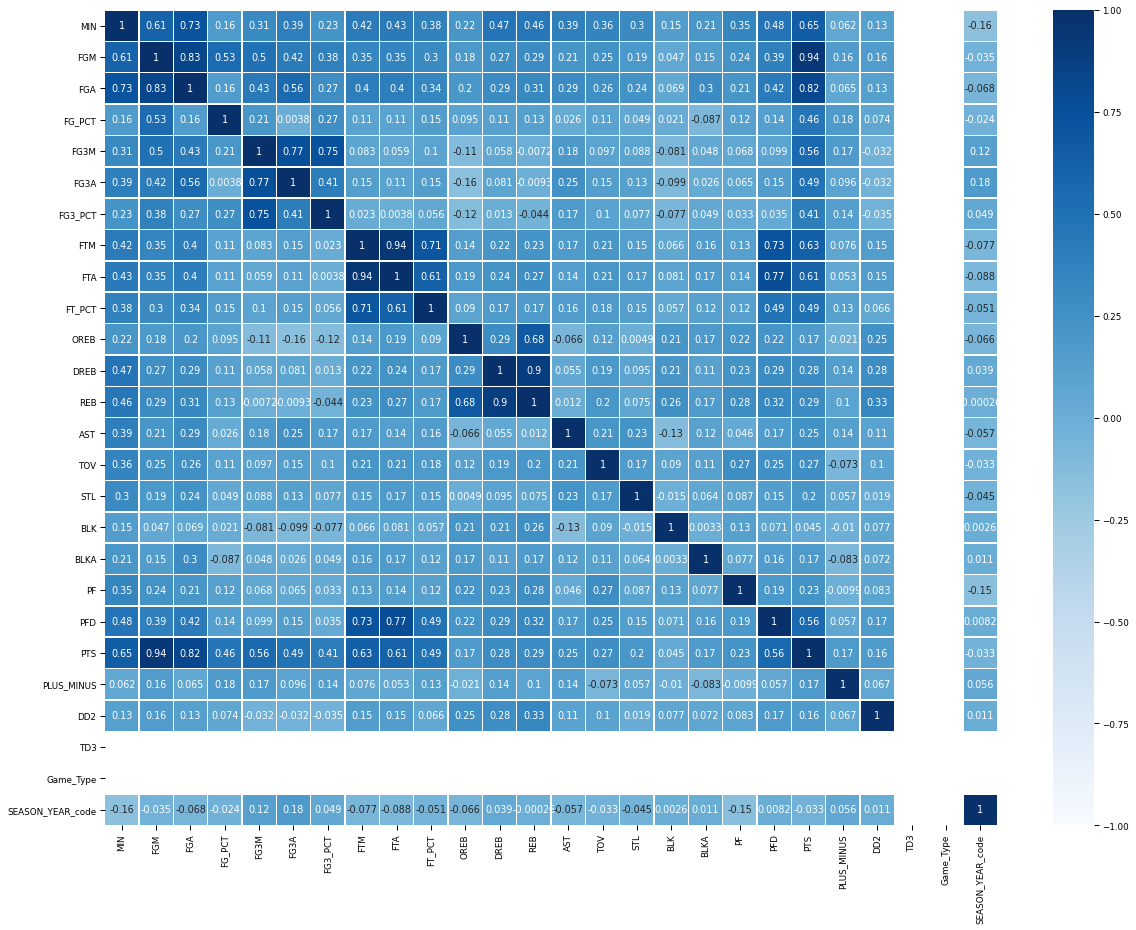

In [27]:
# import seaborn as sns
plt.figure(figsize=(20,15))
sns.set_context("paper", font_scale=1)

# sns.heatmap(df.corr(), annot=True, cmap='Blues',vmin=-1, vmax=1, square=False, linewidths=0.5)
print("")
print("Pre Season")
sns.heatmap(df_X_PreSeason.corr(), annot=True, cmap='Blues',vmin=-1, vmax=1, square=False, linewidths=0.5)
# display(df_X_PreSeason)



Regular Season


<AxesSubplot:>

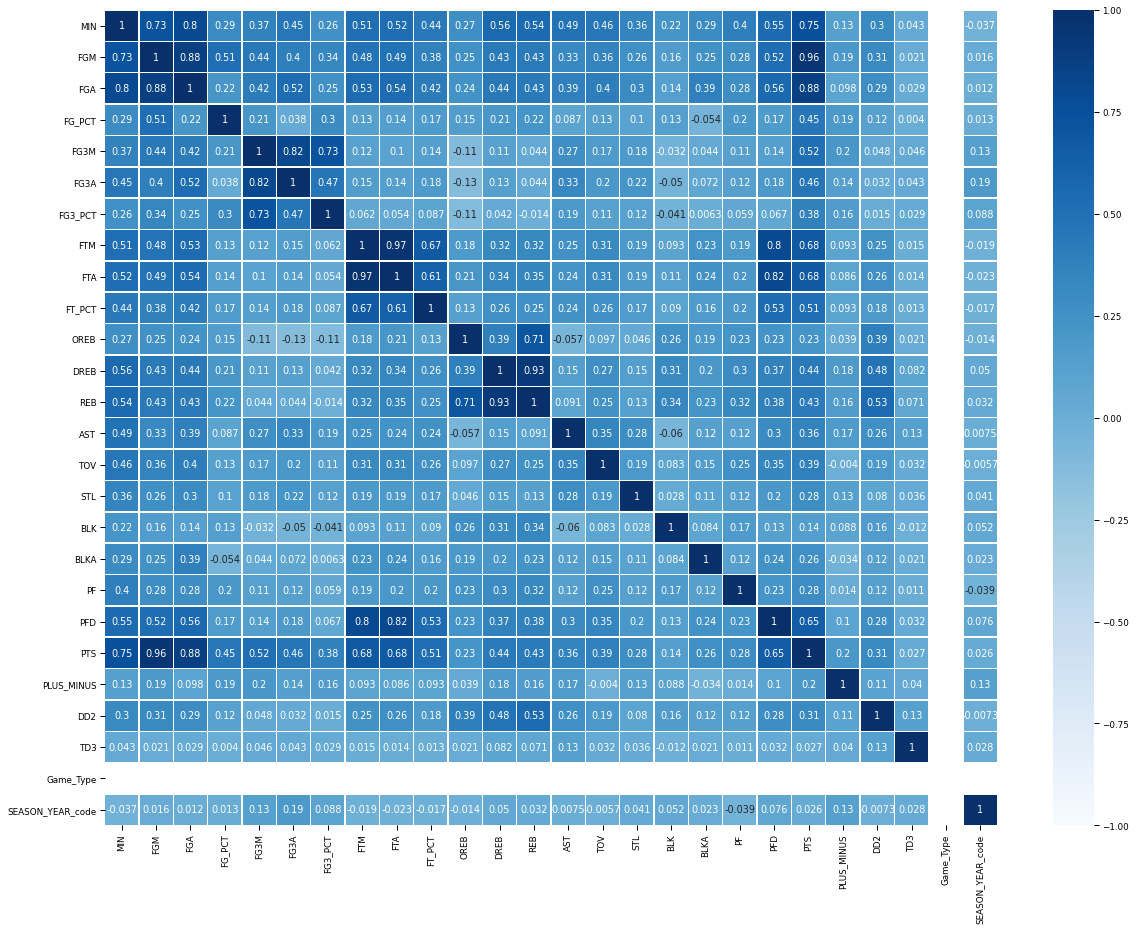

In [28]:
plt.figure(figsize=(20,15))
sns.set_context("paper", font_scale=1)
print("")
print("Regular Season")
sns.heatmap(df_X_RegularSeason.corr(), annot=True, cmap='Blues',vmin=-1, vmax=1, square=False, linewidths=0.5)
# display(df_X_RegularSeason)



Playoffs


<AxesSubplot:>

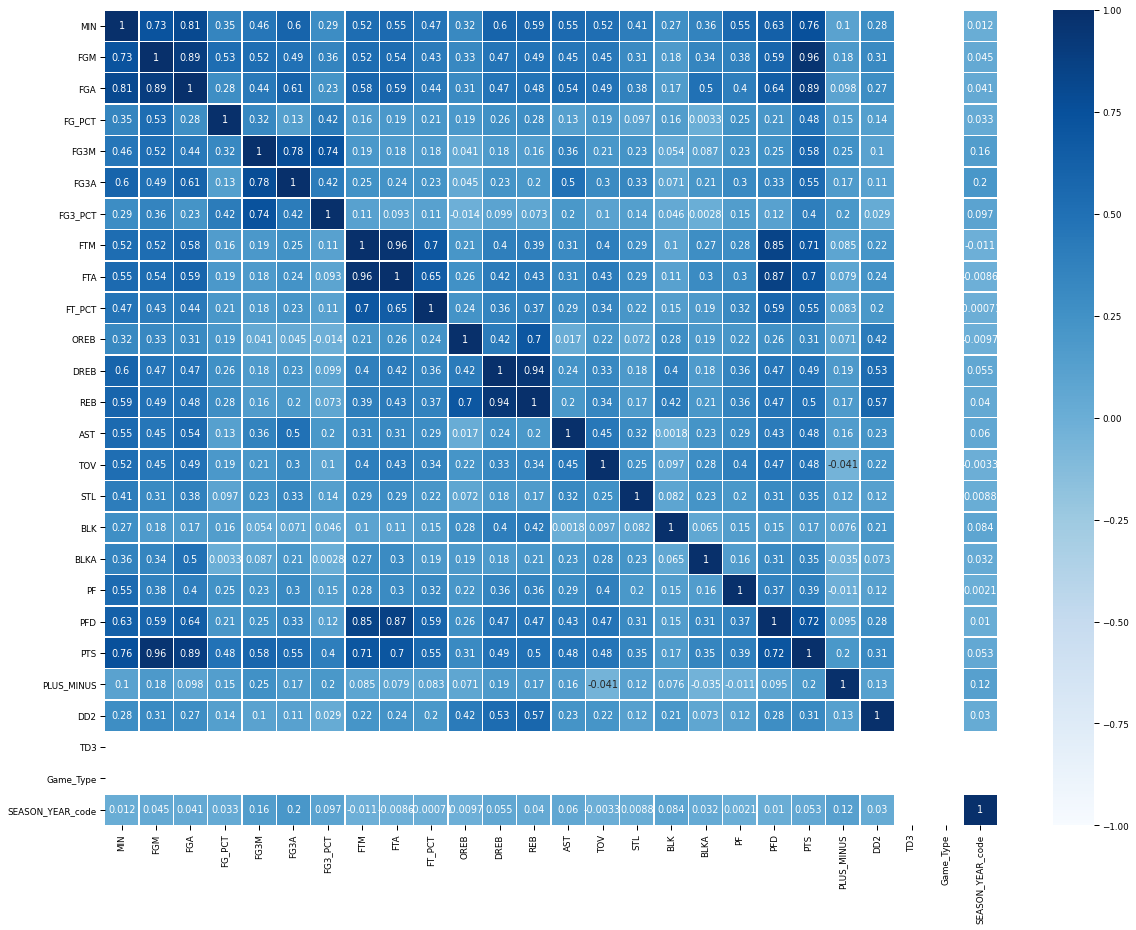

In [29]:
plt.figure(figsize=(20,15))
sns.set_context("paper", font_scale=1)
print("")
print("Playoffs")
sns.heatmap(df_X_Playoffs.corr(), annot=True, cmap='Blues',vmin=-1, vmax=1, square=False, linewidths=0.5)
# display(df_X_Playoffs)

## Section : Remove additional unwanted fields based on Heat Map / Correlation Matrix

## NOT ACTIVE

In [30]:
# Remove unwanted/useless attributes
unwanted_list_02 = []

for k in unwanted_list_02:
    X_headers_list.remove(k)

# Remaining attributes
# VALIDATION CODE 
if debug_active == 'yes':
    display(X_headers_list)

['MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'DD2',
 'TD3',
 'Game_Type',
 'SEASON_YEAR_code']

## Section : Re-check Heat Map / Correlation Matrix

## NOT ACTIVE

In [31]:
# Reuse code for previous Heat Maps

# Section 6: Modeling and Analysis

## Section 6a: Prepare train and test data

In [32]:
# Select a season 
# gameTypeListed = ['Pre Season', 'Regular Season', 'Playoffs']
# gameTypeListed_code = [1, 2, 0]

# gameType = 2
if gameType == 0:
    X = df_X_PreSeason
    Y = df_Y_PreSeason
elif gameType == 1:
    X = df_X_RegularSeason
    Y = df_Y_RegularSeason
elif gameType == 2:
    X = df_X_Playoffs
    Y = df_Y_Playoffs

# Split the code into training and test dataset 0.7/0.3
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = test_size_val, random_state = random_state_val)

# Validate the split at a high level
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

# VALIDATION CODE 
if debug_active == 'yes':
    print('Season Type: ', gameType)
    df_Encoded.to_csv('DAT205_Output_All.csv') 
    X_train.to_csv('DAT205_Output_Split_X_train.csv') 
    X_test.to_csv('DAT205_Output_Split_X_test.csv') 
    Y_train.to_csv('DAT205_Output_Split_Y_train.csv') 
    Y_test.to_csv('DAT205_Output_Split_Y_test.csv') 
    display(X_train)
    display(Y_train)


(713, 26) (713, 1)
(306, 26) (306, 1)
Season Type:  2


,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,SEASON_YEAR_code
437309,19.933333,5,6,0.833,1,2,0.500,2,2,1.000,...,1,0,1,1,13,11,0,0,2,14
346243,42.583333,3,13,0.231,1,7,0.143,0,0,0.000,...,0,1,5,3,7,7,0,0,2,11
437705,33.150000,15,22,0.682,4,8,0.500,3,3,1.000,...,0,0,3,2,37,37,0,0,2,14
285882,37.083333,3,13,0.231,0,4,0.000,8,8,1.000,...,1,0,2,5,14,-10,0,0,2,9
346925,27.350000,3,8,0.375,0,0,0.000,3,3,1.000,...,1,1,5,4,9,16,0,0,2,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113679,39.233333,7,14,0.500,3,6,0.500,7,8,0.875,...,0,0,2,3,24,-13,0,0,2,3
345811,35.998333,8,18,0.444,0,0,0.000,6,6,1.000,...,0,0,4,4,22,-11,0,0,2,11
437199,18.700000,5,8,0.625,0,1,0.000,0,1,0.000,...,0,0,5,1,10,11,0,0,2,14
347300,14.650000,2,4,0.500,0,1,0.000,0,1,0.000,...,0,1,1,2,4,-1,0,0,2,11


,WL
437309,1
346243,0
437705,1
285882,0
346925,1
...,...
113679,0
345811,0
437199,1
347300,0


In [33]:
# VALIDATION CODE 
if debug_active == 'yes':
    display(X)
    display(Y)

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,DD2,TD3,Game_Type,SEASON_YEAR_code
83791,3.250000,1,2,0.500,1,2,0.500,0,0,0.000,...,0,0,0,0,3,2,0,0,2,2
83792,40.000000,4,9,0.444,0,1,0.000,4,6,0.667,...,0,0,5,3,12,-10,0,0,2,2
83793,44.900000,4,5,0.800,0,0,0.000,1,2,0.500,...,1,1,4,1,9,2,0,0,2,2
83794,12.000000,0,1,0.000,0,0,0.000,0,0,0.000,...,0,0,2,2,0,3,0,0,2,2
83797,40.433333,6,11,0.545,2,2,1.000,3,4,0.750,...,1,1,3,2,17,-5,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465020,25.583333,8,14,0.571,2,4,0.500,4,4,1.000,...,1,0,2,2,22,17,0,0,2,15
465022,34.416667,4,8,0.500,3,5,0.600,1,1,1.000,...,2,0,5,1,12,18,0,0,2,15
465035,7.411667,0,1,0.000,0,1,0.000,0,0,0.000,...,0,0,1,0,0,11,0,0,2,15
465047,38.683333,11,15,0.733,8,10,0.800,0,1,0.000,...,1,1,2,2,30,14,1,0,2,15


,WL
83791,0
83792,0
83793,0
83794,0
83797,0
...,...
465020,1
465022,1
465035,1
465047,1


## Section 6b: Apply Logistic Regression on the split train/test dataset

In [34]:
# np.isnan(df_Encoded.any())
# np.isfinite(df_Encoded.all())

# np.any(np.isnan(df_Encoded))
# np.all(np.isfinite(df_Encoded))

In [35]:
# Notes
# LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#                    intercept_scaling=1, l1_ratio=None, max_iter=100,
#                    multi_class='warn', n_jobs=None, penalty='l2',
#                    random_state=0, solver='liblinear', tol=0.0001, verbose=0,
#                    warm_start=False)

# Create the model
LogRegM = LogisticRegression(C=1, solver='liblinear', random_state = random_state_val)

# Train the model
LogRegM.fit(X_train, Y_train.values.ravel())

# Predict using test data
Y_pred = LogRegM.predict(X_test)

# Y_pred = pd.DataFrame(Y_pred, columns = ["WL_code"])
# df = pd.DataFrame(data=numpy_data, index=["row1", "row2"], columns=["column1", "column2"])
# VALIDATION CODE 
if debug_active == 'yes':
    display(Y_pred)

array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,

## Confusion Matrix Analysis Notes
https://www.google.com/search?q=confusion+matrix&rlz=1C1GCEA_enCA849CA849&oq=confusion+&aqs=chrome.1.69i57j0i433l2j0j0i433j0l5.2966j0j7&sourceid=chrome&ie=UTF-8

## Analysis score notes 
https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case

### Compute your model’s analysis

In [36]:
accuracy_score_LogRegM = accuracy_score(Y_test, Y_pred)
f1_score_LogRegM = f1_score(Y_test, Y_pred)
recall_score_LogRegM = recall_score(Y_test, Y_pred)
precision_score_LogRegM = precision_score(Y_test, Y_pred)
classification_report_LogRegM = classification_report(Y_test, Y_pred)
confusion_matrix_LogRegM = confusion_matrix(Y_test, Y_pred)
cm = confusion_matrix_LogRegM
sensitivity_LogRegM = cm[0,0]/(cm[0,0]+cm[0,1])
specificity_LogRegM = cm[1,1]/(cm[1,0]+cm[1,1])


# VALIDATION CODE 
if debug_active == 'yes':
    print('Accuracy:', numFormat.format(accuracy_score_LogRegM))
    print('F1 score:', numFormat.format(f1_score_LogRegM))
    print('Recall:', numFormat.format(recall_score_LogRegM))
    print('Precision:', numFormat.format(precision_score_LogRegM))
    print('Sensitivity : ', numFormat.format(sensitivity_LogRegM))
    print('Specificity : ', numFormat.format(specificity_LogRegM))
    print('\n clasification report:\n', classification_report_LogRegM)
    print('\n confussion matrix:\n',confusion_matrix_LogRegM)

Accuracy: 0.7255
F1 score: 0.7042
Recall: 0.7353
Precision: 0.6757
Sensitivity :  0.7176
Specificity :  0.7353

 clasification report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74       170
           1       0.68      0.74      0.70       136

    accuracy                           0.73       306
   macro avg       0.72      0.73      0.72       306
weighted avg       0.73      0.73      0.73       306


 confussion matrix:
 [[122  48]
 [ 36 100]]


In [37]:
# Feature Importance
importance = LogRegM.coef_[0]
array_importance=[]
# summarize feature importance
for i,v in enumerate(importance):
    array_importance.append(v)
    # print('Feature: %0d, Score: %.5f' % (i,v))

# # Convert to dataframe feature_importances results
df_feature_importance_values = pd.DataFrame(array_importance)
df_feature_importance_values.rename(columns={0:'Feature Importance'}, inplace=True)

# # Convert to dataframe feature labels
df_feature_names = pd.DataFrame(list(X.columns))
df_feature_names.rename(columns={0:'Feature'}, inplace=True)

# # Merge the dataframes for feature labels and feature_importances results
df_feature_importance_LogRegM = pd.concat([df_feature_names, df_feature_importance_values], axis=1)
# df_feature_importance

df_feature_importance_LogRegM.sort_values('Feature Importance', ascending=False, inplace=True)

# VALIDATION CODE 
if debug_active == 'yes':
    df_feature_importance_LogRegM

## Section 6c:  Apply Decision Tree Classifier on the split train/test dataset



In [38]:
# Create the model
DTM = DecisionTreeClassifier()

# Train the model
DTM.fit(X_train, Y_train)

# Predict using test data
Y_pred = DTM.predict(X_test)

In [39]:
accuracy_score_DTM = accuracy_score(Y_test, Y_pred)
f1_score_DTM = f1_score(Y_test, Y_pred)
recall_score_DTM = recall_score(Y_test, Y_pred)
precision_score_DTM = precision_score(Y_test, Y_pred)
classification_report_DTM = classification_report(Y_test, Y_pred)
confusion_matrix_DTM = confusion_matrix(Y_test, Y_pred)
cm = confusion_matrix_DTM
sensitivity_DTM = cm[0,0]/(cm[0,0]+cm[0,1])
specificity_DTM = cm[1,1]/(cm[1,0]+cm[1,1])

# VALIDATION CODE 
if debug_active == 'yes':
    print('Accuracy:', numFormat.format(accuracy_score_DTM))
    print('F1 score:', numFormat.format(f1_score_DTM))
    print('Recall:', numFormat.format(recall_score_DTM))
    print('Precision:', numFormat.format(precision_score_DTM))
    print('Sensitivity : ', numFormat.format(sensitivity_DTM))
    print('Specificity : ', numFormat.format(specificity_DTM))
    print('\n clasification report:\n', classification_report_DTM)
    print('\n confussion matrix:\n',confusion_matrix_DTM)

Accuracy: 0.6536
F1 score: 0.6074
Recall: 0.6029
Precision: 0.6119
Sensitivity :  0.6941
Specificity :  0.6029

 clasification report:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69       170
           1       0.61      0.60      0.61       136

    accuracy                           0.65       306
   macro avg       0.65      0.65      0.65       306
weighted avg       0.65      0.65      0.65       306


 confussion matrix:
 [[118  52]
 [ 54  82]]


In [40]:
# Feature Importance
importance = DTM.feature_importances_
array_importance=[]
# summarize feature importance
for i,v in enumerate(importance):
    array_importance.append(v)
    # print('Feature: %0d, Score: %.5f' % (i,v))

# # Convert to dataframe feature_importances results
df_feature_importance_values = pd.DataFrame(array_importance)
df_feature_importance_values.rename(columns={0:'Feature Importance'}, inplace=True)

# # Convert to dataframe feature labels
df_feature_names = pd.DataFrame(list(X.columns))
df_feature_names.rename(columns={0:'Feature'}, inplace=True)

# # Merge the dataframes for feature labels and feature_importances results
df_feature_importance_DTM = pd.concat([df_feature_names, df_feature_importance_values], axis=1)
# df_feature_importance

df_feature_importance_DTM.sort_values('Feature Importance', ascending=False, inplace=True)

# VALIDATION CODE 
if debug_active == 'yes':
    df_feature_importance_DTM

## Section 6d: Apply Random Forest Classifier on the split train/test dataset

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
# Create the model
RFM = RandomForestClassifier(max_depth=2, random_state=0)

# Train the model
RFM.fit(X_train, Y_train.values.ravel())

# Predict using test data
Y_pred = RFM.predict(X_test)

In [43]:
display(Y_train)
display(Y_pred)

,WL
437309,1
346243,0
437705,1
285882,0
346925,1
...,...
113679,0
345811,0
437199,1
347300,0


array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,

In [44]:
accuracy_score_RFM = accuracy_score(Y_test, Y_pred)
f1_score_RFM = f1_score(Y_test, Y_pred)
recall_score_RFM = recall_score(Y_test, Y_pred)
precision_score_RFM = precision_score(Y_test, Y_pred)
classification_report_RFM = classification_report(Y_test, Y_pred)
confusion_matrix_RFM = confusion_matrix(Y_test, Y_pred)
cm = confusion_matrix_RFM
sensitivity_RFM = cm[0,0]/(cm[0,0]+cm[0,1])
specificity_RFM = cm[1,1]/(cm[1,0]+cm[1,1])

# VALIDATION CODE 
if debug_active == 'yes':
    print('Accuracy:', numFormat.format(accuracy_score_RFM))
    print('F1 score:', numFormat.format(f1_score_RFM))
    print('Recall:', numFormat.format(recall_score_RFM))
    print('Precision:', numFormat.format(precision_score_RFM))
    print('Sensitivity : ', numFormat.format(sensitivity_RFM))
    print('Specificity : ', numFormat.format(specificity_RFM))
    print('\n clasification report:\n', classification_report_RFM)
    print('\n confussion matrix:\n',confusion_matrix_RFM)

Accuracy: 0.7516
F1 score: 0.6960
Recall: 0.6397
Precision: 0.7632
Sensitivity :  0.8412
Specificity :  0.6397

 clasification report:
               precision    recall  f1-score   support

           0       0.74      0.84      0.79       170
           1       0.76      0.64      0.70       136

    accuracy                           0.75       306
   macro avg       0.75      0.74      0.74       306
weighted avg       0.75      0.75      0.75       306


 confussion matrix:
 [[143  27]
 [ 49  87]]


In [45]:
# Feature Importance
importance = RFM.feature_importances_
array_importance=[]
# summarize feature importance
for i,v in enumerate(importance):
    array_importance.append(v)
    # print('Feature: %0d, Score: %.5f' % (i,v))

# # Convert to dataframe feature_importances results
df_feature_importance_values = pd.DataFrame(array_importance)
df_feature_importance_values.rename(columns={0:'Feature Importance'}, inplace=True)

# # Convert to dataframe feature labels
df_feature_names = pd.DataFrame(list(X.columns))
df_feature_names.rename(columns={0:'Feature'}, inplace=True)

# # Merge the dataframes for feature labels and feature_importances results
df_feature_importance_RFM = pd.concat([df_feature_names, df_feature_importance_values], axis=1)
# df_feature_importance

df_feature_importance_RFM.sort_values('Feature Importance', ascending=False, inplace=True)

# VALIDATION CODE 
if debug_active == 'yes':
    df_feature_importance_RFM

# Section 7: Cross Validation Scores

In [46]:
seed = random_state_val
# seed = 0

loan_models = []
# loan_models.append(('Logistic Regression', LogisticRegression()))
loan_models.append(('Decision Tree', DecisionTreeClassifier()))
# loan_models.append(('KNN', KNeighborsClassifier()))
# loan_models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
# loan_models.append(('Gaussian', GaussianNB()))
# loan_models.append(('SVM', SVC()))
loan_models.append(('Random Forest', RandomForestClassifier()))

cross_val_scores = []
model_keys = []

df_cross_val_score = []
df_cross_val_score_headers = [0,1,2,3]
df_cross_val_score = pd.DataFrame (df_cross_val_score, columns = df_cross_val_score_headers)

# VALIDATION CODE 
# if debug_active == 'yes':
#     nullFieldAnalysis(df_cross_val_score)

df_Addscore = []
scoring = 'accuracy'
for model_key, loan_model in loan_models:
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
    cross_val_score = model_selection.cross_val_score(loan_model, X_train, Y_train.values.ravel(), cv=kfold, scoring=scoring)
    cross_val_scores.append(cross_val_score)
    model_keys.append(model_key)
    msg = "%s: cross val mean -> %f , cross val std -> %f, kfold variance -> %f" % (model_key, cross_val_score.mean(), cross_val_score.std(), cross_val_score.var())
    df_Addscore = pd.Series([model_key, cross_val_score.mean(), cross_val_score.std(), cross_val_score.var()])
    df_cross_val_score = df_cross_val_score.append(df_Addscore, ignore_index=True)
    print(msg)

df_cross_val_score.columns = ['Model_Key','Cross_Value_Score_Mean','Cross_Value_Score_STD','Cross_Value_Score_Var']
# VALIDATION CODE 
if debug_active == 'yes':
    print("")
    print("VALIDATION RESULT")
    display(df_cross_val_score)
    print(model_keys)
    print(cross_val_scores)

Decision Tree: cross val mean -> 0.657649 , cross val std -> 0.047226, kfold variance -> 0.002230
Random Forest: cross val mean -> 0.737656 , cross val std -> 0.050383, kfold variance -> 0.002538

VALIDATION RESULT


,Model_Key,Cross_Value_Score_Mean,Cross_Value_Score_STD,Cross_Value_Score_Var
0,Decision Tree,0.657649,0.047226,0.002230
1,Random Forest,0.737656,0.050383,0.002538


['Decision Tree', 'Random Forest']
[array([0.69444444, 0.68055556, 0.69444444, 0.67605634, 0.70422535,
       0.69014085, 0.64788732, 0.64788732, 0.57746479, 0.56338028]), array([0.66666667, 0.77777778, 0.81944444, 0.8028169 , 0.77464789,
       0.70422535, 0.70422535, 0.73239437, 0.71830986, 0.67605634])]


In [47]:
# # WORK IN PROGRESS

# # boxplot algorithm comparison

# # plt.rcParams["figure.figsize"] = (15,10)
# # fig = plt.figure()
# # fig.suptitle('Model Comparison')
# # ax = fig.add_subplot(111)
# # sns.boxplot(x = model_keys, y=cross_val_scores, palette = 'Blues')
# # plt.show()

# # plt.style.use('ggplot')
# plotX = pd.Series(model_keys)
# plotY = pd.Series(cross_val_scores)

# df = pd.DataFrame({"model_keys" : plotX, "cross_val_scores" : plotY})
# # plt.rcParams["figure.figsize"] = (15,10)
# # fig = plt.figure()
# # fig.suptitle('Model Comparison')
# # ax = fig.add_subplot(111)
# sns.set(style="whitegrid")
# sns.boxplot(data=df, palette = 'Blues')



# # plt.style.use('ggplot')
# # dummyData.groupby(['quarter', 'brand'])\
# #       .brand.count().unstack().plot.bar(legend=True)
# plt.show()

In [48]:
# TEST CODE

# print(model_keys)
# print(cross_val_scores)


# print(plotX)
# print(plotY)

# Section 8: Summary Report

In [49]:
# Create summary table of metric analysis
df_Metrics = []

df_Metrics_headers = [0,1,2,3,4,5,6]
df_Metrics = pd.DataFrame (df_Metrics, columns = df_Metrics_headers)


df_AddModel = pd.Series(['Decision Tree',accuracy_score_DTM,f1_score_DTM,recall_score_DTM,precision_score_DTM,sensitivity_DTM,specificity_DTM])
df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

# df_AddModel = pd.Series(['K Nearest Neighbors',accuracy_score_KNNM,f1_score_KNNM,recall_score_KNNM,precision_score_KNNM,sensitivity_KNNM,specificity_KNNM])
# df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

# df_AddModel = pd.Series(['Linear Discriminant Analysis',accuracy_score_LDAM,f1_score_LDAM,recall_score_LDAM,precision_score_LDAM,sensitivity_LDAM,specificity_LDAM])
# df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

# df_AddModel = pd.Series(['Gaussian Naive Bayes',accuracy_score_GNBM,f1_score_GNBM,recall_score_GNBM,precision_score_GNBM,sensitivity_GNBM,specificity_GNBM])
# df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

# df_AddModel = pd.Series(['SVM',accuracy_score_SVMM,f1_score_SVMM,recall_score_SVMM,precision_score_SVMM,sensitivity_SVMM,specificity_SVMM])
# df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

df_AddModel = pd.Series(['Random Forest',accuracy_score_RFM,f1_score_RFM,recall_score_RFM,precision_score_RFM,sensitivity_RFM,specificity_RFM])
df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

df_AddModel = pd.Series(['Logistic Regression', accuracy_score_LogRegM,f1_score_LogRegM,recall_score_LogRegM,precision_score_LogRegM,sensitivity_LogRegM,specificity_LogRegM])
df_Metrics = df_Metrics.append(df_AddModel, ignore_index=True)

df_Metrics.columns = ['Model','Accuracy','F1 score','Recall','Precision','Sensitivity','Specificity']

# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Metrics)

# Join dataframes for Metrics and cross_val_scores
df_Summary = pd.concat([df_Metrics,df_cross_val_score], axis=1)
# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Summary)

,Model,Accuracy,F1 score,Recall,Precision,Sensitivity,Specificity
0,Decision Tree,0.653595,0.607407,0.602941,0.611940,0.694118,0.602941
1,Random Forest,0.751634,0.696000,0.639706,0.763158,0.841176,0.639706
2,Logistic Regression,0.725490,0.704225,0.735294,0.675676,0.717647,0.735294


,Model,Accuracy,F1 score,Recall,Precision,Sensitivity,Specificity,Model_Key,Cross_Value_Score_Mean,Cross_Value_Score_STD,Cross_Value_Score_Var
0,Decision Tree,0.653595,0.607407,0.602941,0.611940,0.694118,0.602941,Decision Tree,0.657649,0.047226,0.002230
1,Random Forest,0.751634,0.696000,0.639706,0.763158,0.841176,0.639706,Random Forest,0.737656,0.050383,0.002538
2,Logistic Regression,0.725490,0.704225,0.735294,0.675676,0.717647,0.735294,NaN,NaN,NaN,NaN


In [50]:
# Clean up columns by dropping columns of duplicate data (Model_Key)
df_Summary.drop(['Model_Key'], axis=1, inplace=True)
# df_Summary.drop(columns=['Model_Key'], inplace=True)
# VALIDATION CODE 
if debug_active == 'yes':
    display(df_Summary)


,Model,Accuracy,F1 score,Recall,Precision,Sensitivity,Specificity,Cross_Value_Score_Mean,Cross_Value_Score_STD,Cross_Value_Score_Var
0,Decision Tree,0.653595,0.607407,0.602941,0.611940,0.694118,0.602941,0.657649,0.047226,0.002230
1,Random Forest,0.751634,0.696000,0.639706,0.763158,0.841176,0.639706,0.737656,0.050383,0.002538
2,Logistic Regression,0.725490,0.704225,0.735294,0.675676,0.717647,0.735294,NaN,NaN,NaN


In [51]:
print("================= Results Summary ==================\n")

print("==================== Attributes ======================")
print('----------------- Removed attributes -----------------')
display(unwanted_list_01)
print('\n------ Removed attributes - Heat Map / Correlation Matrix ---- ')
display(unwanted_list_02)

print('\n------------------- Applied attributes --------------------')
display(X_headers_list)

print("\n ================= Model Analysis Summary ==================\n")
display(df_Summary)

print('\n\n----------------- Logistic Regression --------------------')
print('Accuracy:', numFormat.format(accuracy_score_LogRegM))
print('F1 score:', numFormat.format(f1_score_LogRegM))
print('Recall:', numFormat.format(recall_score_LogRegM))
print('Precision:', numFormat.format(precision_score_LogRegM))
print('Sensitivity : ', numFormat.format(sensitivity_LogRegM))
print('Specificity : ', numFormat.format(specificity_LogRegM))

print('\n clasification report:\n', classification_report_LogRegM)
print('\n confussion matrix:\n',confusion_matrix_LogRegM)
print("\nFeature Importance")
display(df_feature_importance_LogRegM)

print('\n\n-------------------- Decision Tree -----------------------\n')
print('Accuracy:', numFormat.format(accuracy_score_DTM))
print('F1 score:', numFormat.format(f1_score_DTM))
print('Recall:', numFormat.format(recall_score_DTM))
print('Precision:', numFormat.format(precision_score_DTM))
print('Sensitivity : ', numFormat.format(sensitivity_DTM))
print('Specificity : ', numFormat.format(specificity_DTM))

print('\n clasification report:\n', classification_report_DTM)
print('\n confussion matrix:\n',confusion_matrix_DTM)
print("\nFeature Importance")
display(df_feature_importance_DTM)

# print('\n\n------------- Linear Discriminant Analysis ---------------\n')
# print('\n clasification report:\n', classification_report_LDAM)
# print('\n confussion matrix:\n',confusion_matrix_LDAM)
# print("\nFeature Importance")
# display(df_feature_importance_LDAM)

print('\n\n-------------------- Random Forest -----------------------\n')
print('Accuracy:', numFormat.format(accuracy_score_RFM))
print('F1 score:', numFormat.format(f1_score_RFM))
print('Recall:', numFormat.format(recall_score_RFM))
print('Precision:', numFormat.format(precision_score_RFM))
print('Sensitivity : ', numFormat.format(sensitivity_RFM))
print('Specificity : ', numFormat.format(specificity_RFM))

print('\n clasification report:\n', classification_report_RFM)
print('\n confussion matrix:\n',confusion_matrix_RFM)
print("\nFeature Importance")
display(df_feature_importance_RFM)



================= Results Summary ==================

==================== Attributes ======================
----------------- Removed attributes -----------------


['PLAYER_ID',
 'TEAM_ID',
 'PLAYER_NAME',
 'TEAM_ABBREVIATION',
 'TEAM_NAME',
 'GAME_ID',
 'GAME_DATE',
 'MATCHUP']


------ Removed attributes - Heat Map / Correlation Matrix ---- 


[]


------------------- Applied attributes --------------------


['MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'DD2',
 'TD3',
 'Game_Type',
 'SEASON_YEAR_code']


 ================= Model Analysis Summary ==================



,Model,Accuracy,F1 score,Recall,Precision,Sensitivity,Specificity,Cross_Value_Score_Mean,Cross_Value_Score_STD,Cross_Value_Score_Var
0,Decision Tree,0.653595,0.607407,0.602941,0.611940,0.694118,0.602941,0.657649,0.047226,0.002230
1,Random Forest,0.751634,0.696000,0.639706,0.763158,0.841176,0.639706,0.737656,0.050383,0.002538
2,Logistic Regression,0.725490,0.704225,0.735294,0.675676,0.717647,0.735294,NaN,NaN,NaN




----------------- Logistic Regression --------------------
Accuracy: 0.7255
F1 score: 0.7042
Recall: 0.7353
Precision: 0.6757
Sensitivity :  0.7176
Specificity :  0.7353

 clasification report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74       170
           1       0.68      0.74      0.70       136

    accuracy                           0.73       306
   macro avg       0.72      0.73      0.72       306
weighted avg       0.73      0.73      0.73       306


 confussion matrix:
 [[122  48]
 [ 36 100]]

Feature Importance


,Feature,Feature Importance
22,DD2,0.341335
21,PLUS_MINUS,0.135990
4,FG3M,0.127677
25,SEASON_YEAR_code,0.119114
16,BLK,0.108239
19,PFD,0.064886
10,OREB,0.062368
18,PF,0.060803
20,PTS,0.055178
15,STL,0.041544




-------------------- Decision Tree -----------------------

Accuracy: 0.6536
F1 score: 0.6074
Recall: 0.6029
Precision: 0.6119
Sensitivity :  0.6941
Specificity :  0.6029

 clasification report:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69       170
           1       0.61      0.60      0.61       136

    accuracy                           0.65       306
   macro avg       0.65      0.65      0.65       306
weighted avg       0.65      0.65      0.65       306


 confussion matrix:
 [[118  52]
 [ 54  82]]

Feature Importance


,Feature,Feature Importance
21,PLUS_MINUS,0.341688
0,MIN,0.142027
25,SEASON_YEAR_code,0.087611
2,FGA,0.045314
20,PTS,0.043957
3,FG_PCT,0.041404
5,FG3A,0.038729
13,AST,0.030838
18,PF,0.028885
14,TOV,0.028049




-------------------- Random Forest -----------------------

Accuracy: 0.7516
F1 score: 0.6960
Recall: 0.6397
Precision: 0.7632
Sensitivity :  0.8412
Specificity :  0.6397

 clasification report:
               precision    recall  f1-score   support

           0       0.74      0.84      0.79       170
           1       0.76      0.64      0.70       136

    accuracy                           0.75       306
   macro avg       0.75      0.74      0.74       306
weighted avg       0.75      0.75      0.75       306


 confussion matrix:
 [[143  27]
 [ 49  87]]

Feature Importance


,Feature,Feature Importance
21,PLUS_MINUS,0.308705
25,SEASON_YEAR_code,0.173268
20,PTS,0.065052
0,MIN,0.060750
4,FG3M,0.050635
3,FG_PCT,0.044772
1,FGM,0.043573
12,REB,0.038858
2,FGA,0.032799
11,DREB,0.029888


In [52]:
time_took = time.time() - start_time
print("")
print("")
print("PROCESSING COMPLETE")
print(f"Total Runtime: {hms_string(time_took)}")



PROCESSING COMPLETE
Total Runtime: 0:00:21.52


# End of Code